# Proyecto Inteligencia Computacional - Proyecto 8 - ID 8a

## Integrantes
- Juan Pablo Contreras
- Pascual Marcone

## Ayudante
- Sebastian Guzman

# Dependencias

In [1]:
#libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import importlib

#system
from pathlib import Path
import time

#ai
import torch
from torch import nn
import torchvision
from torch.utils.data import TensorDataset, DataLoader

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import src
importlib.reload(src)

import src.model.train as train
import src.model.ae as ae

import src.probing.linear_probing as lp

import src.utils.plots as plots
import src.utils.gau as gaussian
import src.utils.metrics as metrics

c:\Users\pmarc\.conda\envs\inteli_gpu\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Dataset Setup

In [2]:
stamps_dataset = pd.read_pickle('data/5stamps_dataset.pkl')
dataset_1_21 = pd.read_pickle('data/stamp_dataset_21_new.pkl')

In [3]:
def rename_labels(dataset, old_value, new_value):
    for key in dataset.keys():
        if old_value in dataset[key]:
            dataset[key][new_value] = dataset[key].pop(old_value)

rename_labels(stamps_dataset, 'labels', 'class')
rename_labels(stamps_dataset, 'science', 'images')

In [4]:
importlib.reload(gaussian)

# generate fake gaussian dataset
num_samples = 15000
image_size = 21
border_margin = 4
noise_level = 0.1
brightness = 0.7

gaussian_images = gaussian.generate_gaussian_dataset(num_samples, image_size, border_margin, noise_level, brightness)
gaussian_dataset = TensorDataset(gaussian_images)

### 5stamps_dataset (MODIFICAR PARA DUAL CHANNEL)

In [45]:
# Extract the template and difference data
train_template = torch.tensor(stamps_dataset['Train']['template'], dtype=torch.float32)
validation_template = torch.tensor(stamps_dataset['Validation']['template'], dtype=torch.float32)
test_template = torch.tensor(stamps_dataset['Test']['template'], dtype=torch.float32)

train_difference = torch.tensor(stamps_dataset['Train']['difference'], dtype=torch.float32)
validation_difference = torch.tensor(stamps_dataset['Validation']['difference'], dtype=torch.float32)
test_difference = torch.tensor(stamps_dataset['Test']['difference'], dtype=torch.float32)

train_image = torch.tensor(stamps_dataset['Train']['images'], dtype=torch.float32)
validation_image = torch.tensor(stamps_dataset['Validation']['images'], dtype=torch.float32)
test_image = torch.tensor(stamps_dataset['Test']['images'], dtype=torch.float32)

train_class_0 = torch.tensor(stamps_dataset['Train']['class'], dtype=torch.float32)
validation_class_0 = torch.tensor(stamps_dataset['Validation']['class'], dtype=torch.float32)
test_class_0 = torch.tensor(stamps_dataset['Test']['class'], dtype=torch.float32)

# Reshape the arrays to separate timestamps
num_samples, num_photos, height, width = train_difference.shape
reshaped_train_difference = train_difference.reshape(num_samples * num_photos, height, width)
reshaped_train_template = train_template.repeat_interleave(num_photos, dim=0)
reshaped_train_image = train_image.reshape(train_image.shape[0] * num_photos, height, width)
reshaped_train_class = train_class_0.repeat_interleave(num_photos)

num_samples, num_photos, height, width = validation_difference.shape
reshaped_val_difference = validation_difference.reshape(validation_difference.shape[0] * num_photos, height, width)
reshaped_val_template = validation_template.repeat_interleave(num_photos, dim=0)
reshaped_val_image = validation_image.reshape(validation_image.shape[0] * num_photos, height, width)
reshaped_val_class = validation_class_0.repeat_interleave(num_photos)

num_samples, num_photos, height, width = test_difference.shape
reshaped_test_difference = test_difference.reshape(test_difference.shape[0] * num_photos, height, width)
reshaped_test_template = test_template.repeat_interleave(num_photos, dim=0)
reshaped_test_image = test_image.reshape(test_image.shape[0] * num_photos, height, width)
reshaped_test_class = test_class_0.repeat_interleave(num_photos)

# Combine the template and difference into a 2-channel image
train_dataset = torch.stack((reshaped_train_template, reshaped_train_image, reshaped_train_difference), dim=3)
validation_dataset = torch.stack((reshaped_val_template, reshaped_val_image, reshaped_val_difference), dim=3)
test_dataset = torch.stack((reshaped_test_template, reshaped_test_image, reshaped_test_difference), dim=3)

train_dataset_0 = TensorDataset(train_dataset.permute(0, 3, 1, 2), reshaped_train_class)
validation_dataset_0 = TensorDataset(validation_dataset.permute(0, 3, 1, 2), reshaped_val_class)
test_dataset_0 = TensorDataset(test_dataset.permute(0, 3, 1, 2), reshaped_test_class)

In [111]:
from torch.utils.data import random_split, DataLoader

first = int(len(train_dataset_0)/4)
second = int(len(train_dataset_0)/4)
third = int(len(train_dataset_0)/4)
fourth = len(train_dataset_0) - (first + second + third)

train_subset_0_0, train_subset_0_1, train_subset_0_2, train_subset_0_3 = random_split(train_dataset_0, [first, second, third, fourth], generator=torch.Generator().manual_seed(42))

### stamp_dataset_21_new

In [41]:
train_difference = torch.tensor(dataset_1_21['Train']['images'], dtype=torch.float32)
validation_difference = torch.tensor(dataset_1_21['Validation']['images'], dtype=torch.float32)
test_difference = torch.tensor(dataset_1_21['Test']['images'], dtype=torch.float32)

train_class_1 = torch.tensor(dataset_1_21['Train']['class'], dtype=torch.float32)
validation_class_1 = torch.tensor(dataset_1_21['Validation']['class'], dtype=torch.float32)
test_class_1 = torch.tensor(dataset_1_21['Test']['class'], dtype=torch.float32)

train_difference = (train_difference - train_difference.min()) / (train_difference.max() - train_difference.min())
validation_difference = (validation_difference - validation_difference.min()) / (validation_difference.max() - validation_difference.min())
test_difference = (test_difference - test_difference.min()) / (test_difference.max() - test_difference.min())


# Seleccionar los canales 0 y 2
train_difference_reshaped = train_difference[:, :, :, [0, 1, 2]]
validation_difference_reshaped = validation_difference[:, :, :, [0, 1, 2]]
test_difference_reshaped = test_difference[:, :, :, [0, 1, 2]]

# Permutar las dimensiones para que tengan la forma [batch_size, num_channels, height, width]
train_difference_reshaped_perm = train_difference_reshaped.permute(0, 3, 1, 2)
validation_difference_reshaped_perm = validation_difference_reshaped.permute(0, 3, 1, 2)
test_difference_reshaped_perm = test_difference_reshaped.permute(0, 3, 1, 2)

train_dataset_1 = TensorDataset(train_difference_reshaped_perm, train_class_1)
validation_dataset_1 = TensorDataset(validation_difference_reshaped_perm, validation_class_1)
test_dataset_1 = TensorDataset(test_difference_reshaped_perm, test_class_1)

# Model Train

## Initial Train with more variable database

In [ ]:
importlib.reload(ae)
importlib.reload(train)
importlib.reload(metrics)

#static parameters
max_epochs = 300
criterion = ae.loss_function
batch_size = 100 #100
lr = 0.333e-4 #propuesto en paper astorga

early_stopping = 15
use_gpu = True

model = ae.AE(latent_dim = 42, n_channels=3, name='final_model')


curves_1, tiempo_1, mse_1 = train.train_model(model,
                                            train_dataset_1,
                                            validation_dataset_1,
                                            test_dataset_1,
                                            max_epochs=max_epochs,
                                            criterion=criterion,
                                            batch_size=batch_size,
                                            lr=lr,
                                            augmentation=True,
                                            shuffle_augmentation=False,
                                            early_stop=early_stopping,
                                            use_gpu=use_gpu
                                            )
torch.save(model.state_dict(), 'models/model_1.pth')

metrics.show_curves([curves_1], [model])

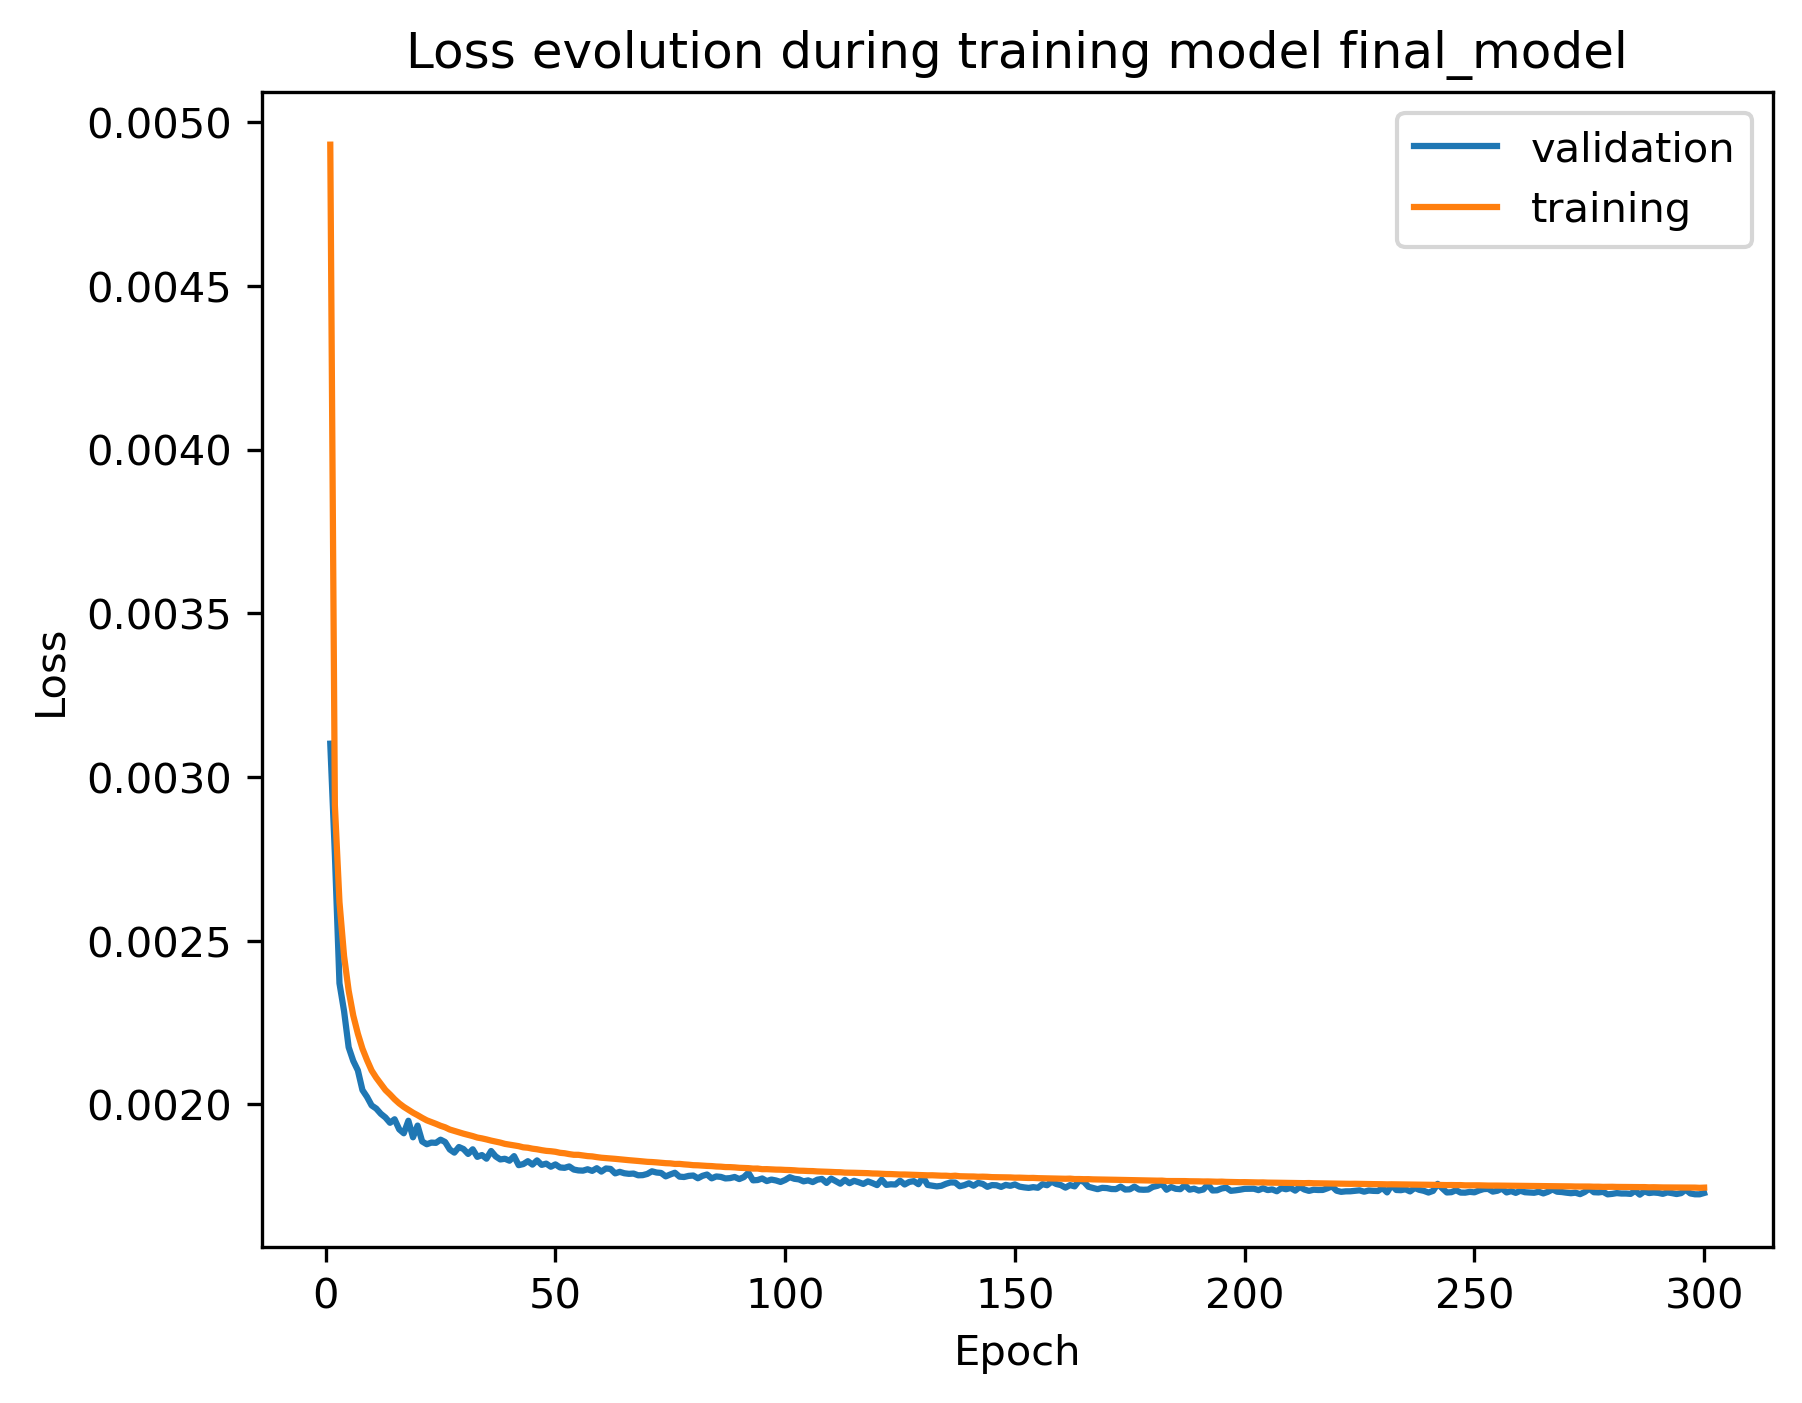

In [53]:
importlib.reload(metrics)
metrics.show_curves([curves_1], [model])
print()

## Train with final database

Augmenting Data ... 
Starting training ...
Epoch 88/150 (Early Stop) -- Iteration 813296 - Batch 9241/9242 - Train loss: 0.00099934 - Val loss: 0.00022253Tiempo total de entrenamiento: 7543.92 [s]

Augmenting Data ... 
Starting training ...
Epoch 17/150 (Early Stop) -- Iteration 157114 - Batch 9241/9242 - Train loss: 0.00125330 - Val loss: 0.00022766Tiempo total de entrenamiento: 1393.41 [s]

Augmenting Data ... 
Starting training ...
Epoch 39/150 (Early Stop) -- Iteration 360438 - Batch 9241/9242 - Train loss: 0.00115640 - Val loss: 0.00021343Tiempo total de entrenamiento: 3312.22 [s]

Augmenting Data ... 
Starting training ...
Epoch 26/150 (Early Stop) -- Iteration 240318 - Batch 9242/9243 - Train loss: 0.00133972 - Val loss: 0.00019519Tiempo total de entrenamiento: 2146.86 [s]



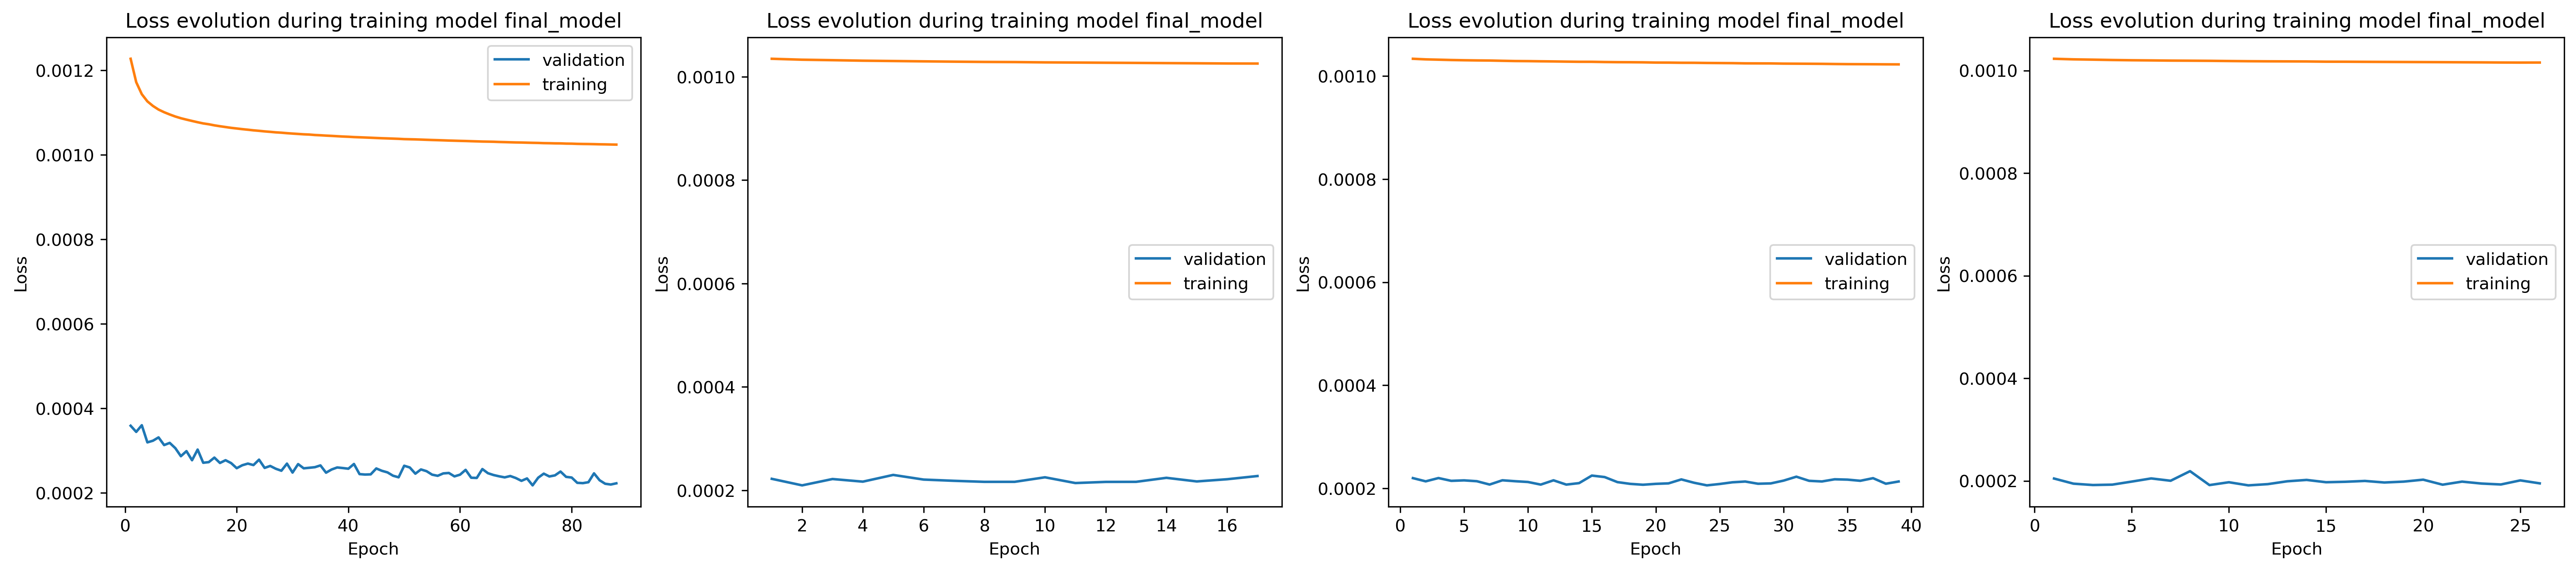

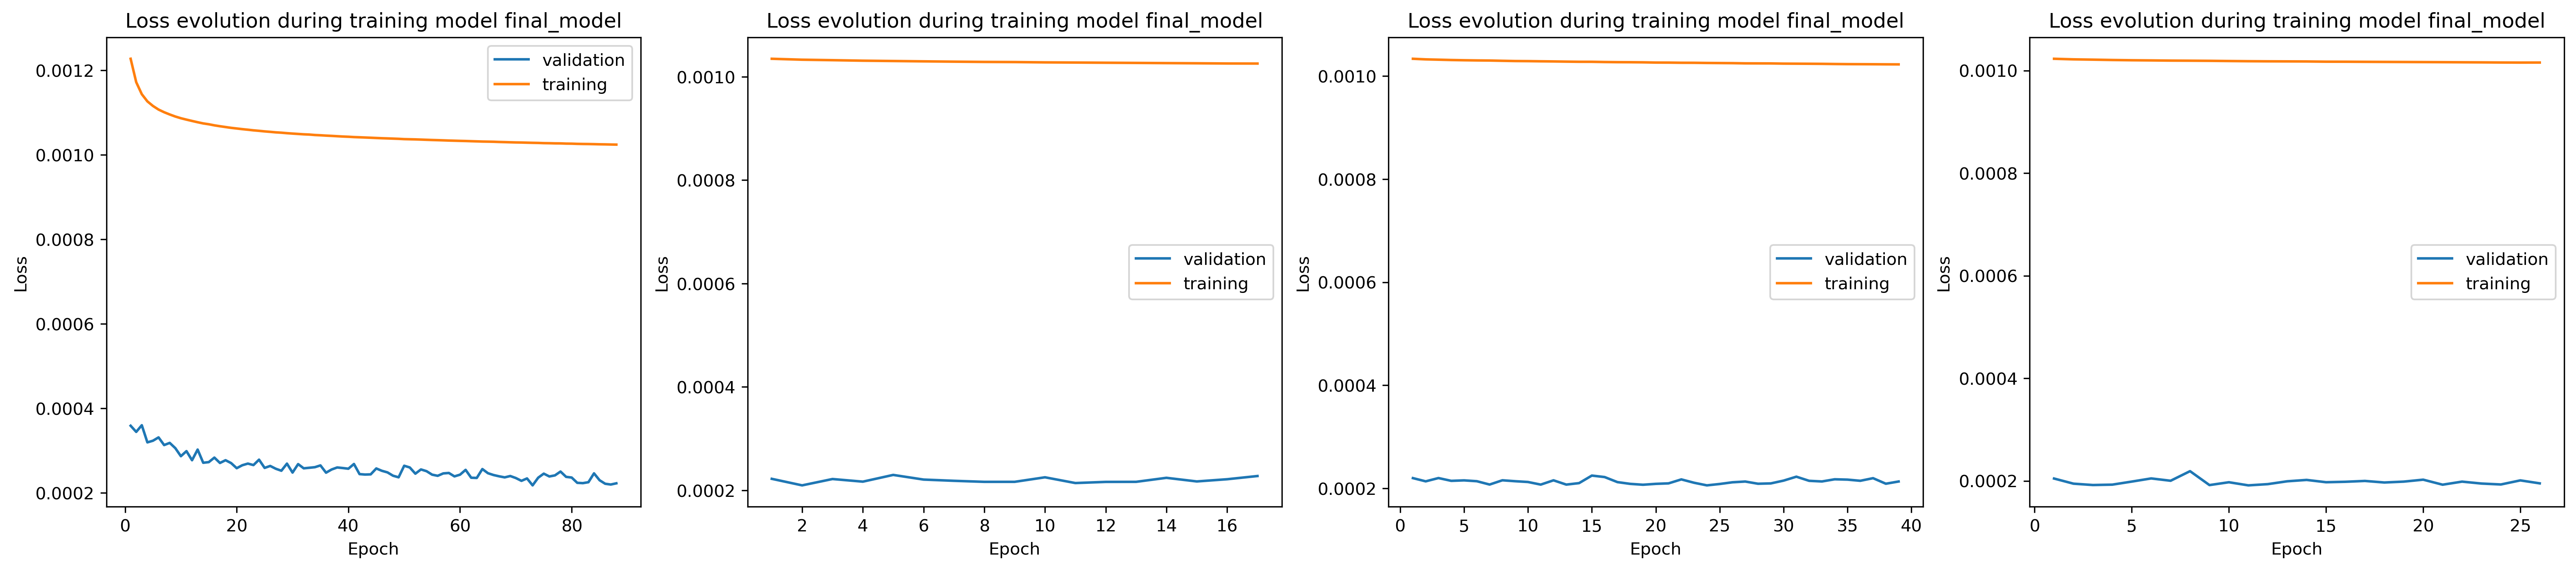

In [112]:
importlib.reload(ae)
importlib.reload(train)
importlib.reload(metrics)

#static parameters
max_epochs = 150
criterion = ae.loss_function
batch_size = 100 #100
lr = 0.333e-4 #propuesto en paper astorga

augmentation = True
suffle = False
early_stopping = 15
use_gpu = True

curves_2_0, tiempo_2_0, mse_2_0 = train.train_model(model,
                                            train_subset_0_0,
                                            validation_dataset_0,
                                            test_dataset_0,
                                            max_epochs=max_epochs,
                                            criterion=criterion,
                                            batch_size=batch_size,
                                            lr=lr,
                                            augmentation=augmentation,
                                            shuffle_augmentation=suffle,
                                            early_stop=early_stopping,
                                            use_gpu=use_gpu
                                            )

torch.save(model.state_dict(), 'models/model_2.pth')

curves_2_1, tiempo_2_1, mse_2_1 = train.train_model(model,
                                            train_subset_0_1,
                                            validation_dataset_0,
                                            test_dataset_0,
                                            max_epochs=max_epochs,
                                            criterion=criterion,
                                            batch_size=batch_size,
                                            lr=lr,
                                            augmentation=augmentation,
                                            shuffle_augmentation=suffle,
                                            early_stop=early_stopping,
                                            use_gpu=use_gpu
                                            )

torch.save(model.state_dict(), 'models/model_2.pth')

curves_2_2, tiempo_2_2, mse_2_2 = train.train_model(model,
                                            train_subset_0_2,
                                            validation_dataset_0,
                                            test_dataset_0,
                                            max_epochs=max_epochs,
                                            criterion=criterion,
                                            batch_size=batch_size,
                                            lr=lr,
                                            augmentation=augmentation,
                                            shuffle_augmentation=suffle,
                                            early_stop=early_stopping,
                                            use_gpu=use_gpu
                                            )

torch.save(model.state_dict(), 'models/model_2.pth')

curves_2_3, tiempo_2_3, mse_2_3 = train.train_model(model,
                                            train_subset_0_3,
                                            validation_dataset_0,
                                            test_dataset_0,
                                            max_epochs=max_epochs,
                                            criterion=criterion,
                                            batch_size=batch_size,
                                            lr=lr,
                                            augmentation=augmentation,
                                            shuffle_augmentation=suffle,
                                            early_stop=early_stopping,
                                            use_gpu=use_gpu
                                            )

torch.save(model.state_dict(), 'models/model_2.pth')

metrics.show_curves([curves_2_0, curves_2_1, curves_2_2, curves_2_3], [model, model, model, model])

# Linear Probing Training

In [113]:
# linear probing settings
lp_epochs = 200
lp_criterion = nn.CrossEntropyLoss()
lp_batch_size = 100
lp_lr = 0.333e-4
use_gpu = True

import src.probing.train as train_lp

In [114]:
importlib.reload(lp)

model.to('cpu')

train_1, val_1, test_1 = lp.get_latent_features([model], train_dataset_1, validation_dataset_1, test_dataset_1)

lp_model_1= lp.LinearClassifier(42, 5, 'with variable database')

lp_curves_1, lp_tiempo_1, lp_labels_1, lp_pred_1 = train_lp.train_model(lp_model_1, train_1[0], val_1[0], test_1[0], lp_epochs, lp_criterion, lp_batch_size, lp_lr, use_gpu)

torch.save(lp_model_1.state_dict(), 'models/lp_model_1.pth')

Epoch 200/200 -- Iteration 145600 - Batch 727/728 - Train loss: 0.577780 - Val loss: 0.7581



In [115]:
importlib.reload(lp)

train_2, val_2, test_2 = lp.get_latent_features([model], train_dataset_0, validation_dataset_0, test_dataset_0)

lp_model_2 = lp.LinearClassifier(42, 3, 'with final database')


lp_curves_2_1, lp_tiempo_2_1, lp_labels_2_1, lp_pred_2_1 = lp.train_model(lp_model_2, train_2[0], val_2[0], test_2[0], lp_epochs, lp_criterion, lp_batch_size, lp_lr, use_gpu)
torch.save(lp_model_2.state_dict(), 'models/lp_model_2.pth')


KeyboardInterrupt



# Metrics

In [116]:
# settings
importlib.reload(plots)
importlib.reload(metrics)
#umap 
n_neighbors = 15
min_dist = 0.1
metric = 'euclidean'
norm = True

In [72]:
print('MSE 1:', mse_1, '\nMSE 2:', mse_2)

MSE 1: 0.0018247352647091878


## Variable database

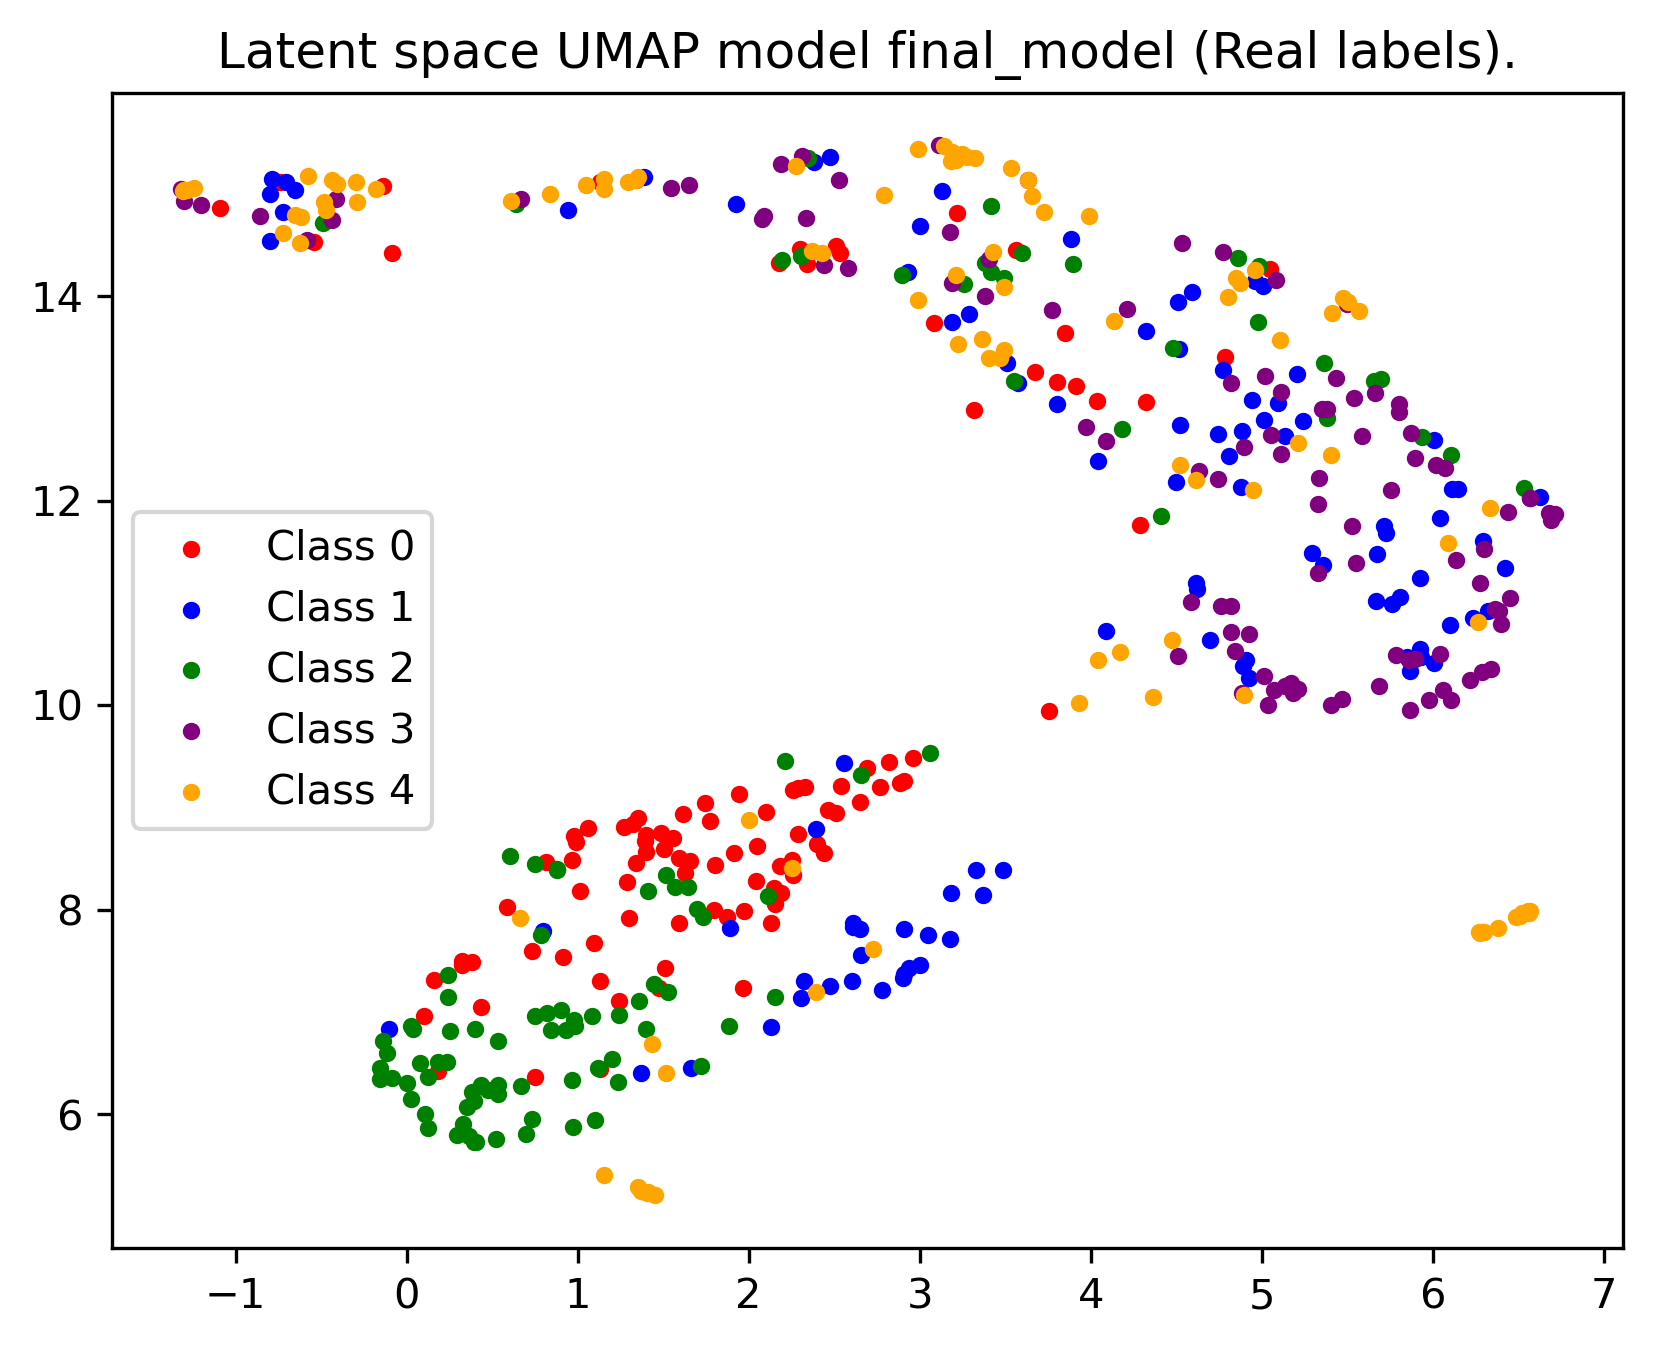

In [117]:
# latent space umap
metrics.plot_umap([model], test_dataset_1.tensors[0], test_class_1, n_neighbors, min_dist, metric, norm)
print()

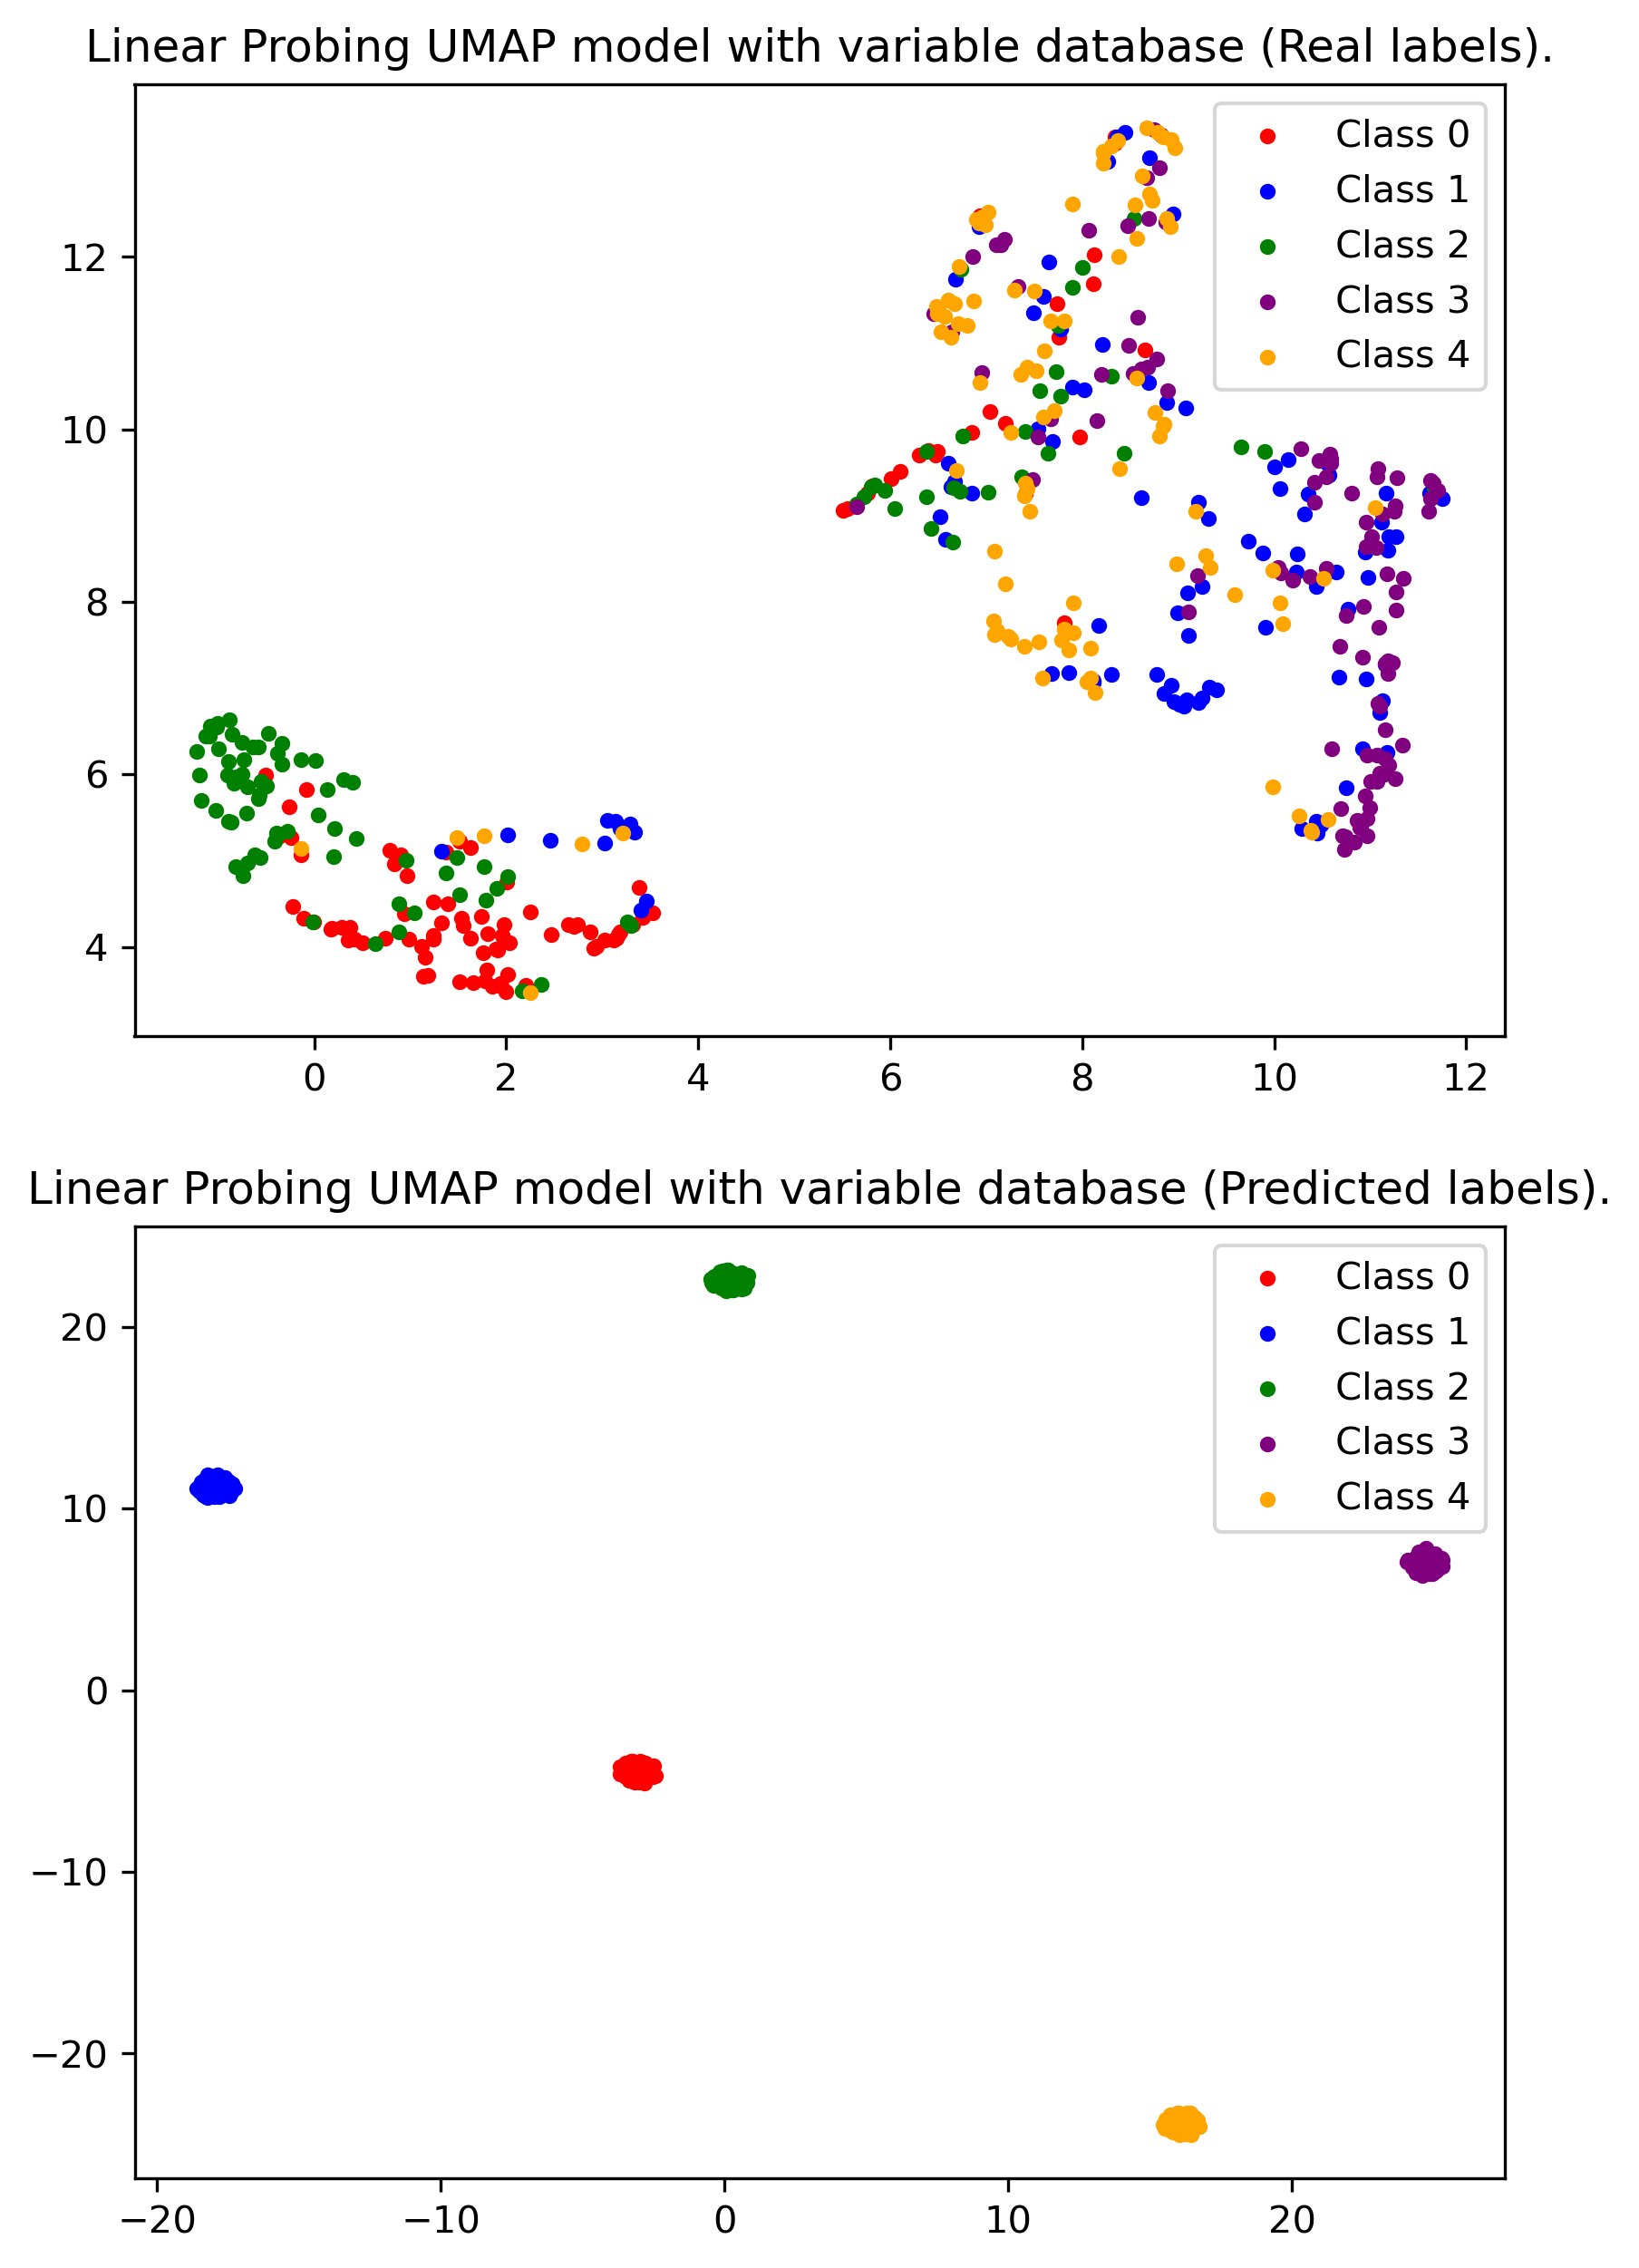

In [118]:
# linear probing umap + confusion matrix
importlib.reload(metrics)

metrics.plot_umap_lp([lp_model_1], test_1, n_neighbors, min_dist, metric, norm)
print()

In [ ]:
# reconstruction examples
plots.plot_example([model], test_dataset_1)
print()

## Final database

In [ ]:
# latent space umap
metrics.plot_umap([model], test_dataset_0.tensors[0], test_class_0, n_neighbors, min_dist, metric, norm)
print()

In [ ]:
# linear probing umap + confusion matrix
metrics.plot_umap_lp([lp_model_2], test_2, n_neighbors, min_dist, metric, norm)
print()

In [ ]:
# reconstruction examples
plots.plot_example([model], test_dataset_0)
print()